In [1]:
# import ROOT
import uproot
import json
import os
from skhep.math.vectors import LorentzVector

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import mplhep
from pprint import pprint as pp

plt.style.use(mplhep.style.ATLAS)

# Create a ROOT dataframe for each dataset
# Note that we load the filenames from an external json file.
path = "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22"
path = "/home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22"
files = json.load(open(os.path.join(os.environ["ROOTSYS"], "tutorials/dataframe", "df106_HiggsToFourLeptons.json")))
processes = files.keys()
df = {}
xsecs = {}
sumws = {}
samples = []
lumi = 10064.0

columns = ['trigE', 'trigM', 
           'lep_eta', 'lep_pt', 'lep_ptcone30', 'lep_etcone20', 
           'lep_type', 'lep_charge', 'lep_phi', 'lep_E', 
           'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'lep_z0', 'mcWeight',
           'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_LepTRIGGER', 'scaleFactor_PILEUP',
          ]


def cut_trigE_trigM(trigE, trigM):
    return np.logical_not(np.logical_or(trigE, trigM))

# https://github.com/scikit-hep/scikit-hep/blob/master/skhep/math/vectors.py#L700
def good_electrons_and_muons(pdg_id, pt, eta, phi, e, trackd0pv, tracksigd0pv, z0):
    for i in range(0, len(pdg_id)):
        p = LorentzVector()
        p.setptetaphie(pt[i] / 1000.0, eta[i], phi[i], e[i] / 1000.0)
        if pdg_id[i] == 11:
            if (pt[i] < 7000 or abs(eta[i]) > 2.47 or abs(trackd0pv[i] / tracksigd0pv[i]) > 5 or abs(z0[i] * math.sin(p.theta())) > 0.5):
                return False
            else:
                if (abs(trackd0pv[i] / tracksigd0pv[i]) > 5 or abs(z0[i] * math.sin(p.theta())) > 0.5):
                    return False
    return True

# https://stackoverflow.com/questions/40045632/adding-a-column-in-pandas-df-using-a-function
def good_lep(lep_eta, lep_pt, lep_ptcone30, lep_etcone20):
    a = np.logical_and(abs(lep_eta) < 2.5, lep_pt > 5000)
    b = np.logical_and(lep_ptcone30 / lep_pt < 0.3, lep_etcone20 / lep_pt < 0.3)
    return np.logical_and(a, b)

def invariant_mass(pt, eta, phi, E):
    leptons = []
    for i in range(0, 4):
        p = LorentzVector()
        p.setptetaphie(pt[i], eta[i], phi[i], E[i])
        leptons.append(p)
    
    return (leptons[0] + leptons[1] + leptons[2] + leptons[3]).mag / 1000.0;

for p in processes:
    for d in files[p]:
        # Construct the dataframes
        folder = d[0] # Folder name
        sample = d[1] # Sample name
        xsecs[sample] = d[2] # Cross-section
        sumws[sample] = d[3] # Sum of weights
        samples.append(sample)
        filepath = "{}/4lep/{}/{}.4lep.root".format(path, folder, sample)
        print(sample, filepath)
        tree = uproot.open(filepath)['mini']
        for batch in tree.iterate(columns, outputtype=pd.DataFrame):
            a = batch
            print(a.shape)

            fail = a[np.vectorize(cut_trigE_trigM)(a.trigE, a.trigM)].index
            a.drop(fail, inplace=True)
            print(a.shape)

            a['good_lep'] = a.apply(lambda x: good_lep(x.lep_eta, x.lep_pt, x.lep_ptcone30, x.lep_etcone20), axis=1)

            print(a.shape)
            a = a[a.apply(lambda x: x.good_lep.sum() == 4, axis=1)]
            print(a.shape)

            a = a[a.apply(lambda x: x.lep_charge[x.good_lep].sum() == 0, axis=1)]
            print(a.shape)

            a['goodlep_sumtypes'] = a.apply(lambda x: x.lep_type[x.good_lep].sum(), axis=1)
            print(a.shape)

            a = a[(a.goodlep_sumtypes == 44) | (a.goodlep_sumtypes == 52) | (a.goodlep_sumtypes == 48)]
            print(a.shape)

            a = a[a.apply(lambda x: good_electrons_and_muons(x.lep_type[x.good_lep], x.lep_pt[x.good_lep], x.lep_eta[x.good_lep], x.lep_phi[x.good_lep], x.lep_E[x.good_lep], x.lep_trackd0pvunbiased[x.good_lep], x.lep_tracksigd0pvunbiased[x.good_lep], x.lep_z0[x.good_lep]), axis=1)]
            print(a.shape)

            a['goodlep_pt'] = a.apply(lambda x: x.lep_pt[x.good_lep], axis=1)
            a['goodlep_eta'] = a.apply(lambda x: x.lep_eta[x.good_lep], axis=1)
            a['goodlep_phi'] = a.apply(lambda x: x.lep_phi[x.good_lep], axis=1)
            a['goodlep_E'] = a.apply(lambda x: x.lep_E[x.good_lep], axis=1)
            print(a.shape)

            a = a[a.apply(lambda x: x.goodlep_pt[0] > 25000 and x.goodlep_pt[1] > 15000 and x.goodlep_pt[2] > 10000, axis=1)]
            print (a.shape)
            
            a['m4l'] = a.apply(lambda x: invariant_mass(x.goodlep_pt, x.goodlep_eta, x.goodlep_phi, x.goodlep_E), axis=1)
            
            if "data" in sample.lower():
                a['weight'] = a.apply(lambda x: 1.0, axis=1)
            else:
                a['weight'] = a.apply(lambda x: x.scaleFactor_ELE * x.scaleFactor_MUON * x.scaleFactor_LepTRIGGER * x.scaleFactor_PILEUP * x.mcWeight * xsecs[sample] / sumws[sample] * lumi, axis=1)
            print (a.shape)
            
            if sample not in df:
                df[sample] = a
                
            else:
                df[sample].append(a)
        

# peek at the last item built for seeing what they may look like
print(sample)
print(df[sample].keys())

data_A /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_A.4lep.root
(39, 18)
(39, 18)
(39, 19)
(30, 19)
(24, 19)
(24, 20)
(21, 20)
(20, 20)
(20, 24)
(18, 24)
(18, 26)
data_B /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_B.4lep.root
(156, 18)
(156, 18)
(156, 19)
(101, 19)
(83, 19)
(83, 20)
(62, 20)
(61, 20)
(61, 24)
(54, 24)
(54, 26)
data_C /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_C.4lep.root
(237, 18)
(237, 18)
(237, 19)
(166, 19)
(141, 19)
(141, 20)
(117, 20)
(115, 20)
(115, 24)
(104, 24)
(104, 26)
data_D /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_D.4lep.root
(400, 18)
(400, 18)
(400, 19)
(286, 19)
(236, 19)
(236, 20)
(206, 20)
(198, 20)
(198, 24)
(179, 24)
(179, 26)
mc_345060.ggH125_ZZ4lep /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root
(104555, 18)
(104555, 18)
(104555, 19)
(93975, 19)
(9259

In [2]:
histos = {}
data_merged = {}
higgs_merged = {}
zz_merged = {}
other_merged = {}
for s in samples:
    # ROOT.RDF.TH1DModel
    # https://root.cern.ch/doc/v614/structROOT_1_1RDF_1_1TH1DModel.html#a01c8a69133957fb9c95c66bc25d51039
    
    # Histo1D
    # https://root.cern.ch/doc/master/classROOT_1_1RDF_1_1RInterface.html#afdea1e017d3e6bae038f1cafcd472b4a
    histos[s] = np.histogram(df[s].m4l, bins=24, range=(80, 170), weights=df[s].weight)
# Run the event loop and merge histograms of the respective processes
pp(files)

{'data': [['Data', 'data_A', 1, 1],
          ['Data', 'data_B', 1, 1],
          ['Data', 'data_C', 1, 1],
          ['Data', 'data_D', 1, 1]],
 'higgs': [['MC', 'mc_345060.ggH125_ZZ4lep', 0.0060239, 27881776.6536],
           ['MC', 'mc_344235.VBFH125_ZZ4lep', 0.0004633012, 3680490.83243]],
 'other': [['MC', 'mc_361106.Zee', 1950.5295, 150277594200],
           ['MC', 'mc_361107.Zmumu', 1950.6321, 147334691090]],
 'zz': [['MC', 'mc_363490.llll', 1.2578, 7538705.8077]]}


data_A [649.27193112  87.90709765 344.77593581 326.58379017 574.64188186
  88.97608995 219.06440674 209.00868348 330.47445522  90.68151163
 140.17351604 189.42390639 208.92963601 239.73146692 388.71916315
 271.60189094 247.3113848   91.91664173]
data_B [183.13756636  92.42066966 197.80514237 133.75873221 163.68010749
 170.65649519 133.28342296 272.65864741 258.87124989 248.55413875
 432.48533471 243.05950251 200.19022577 214.6079016  289.10816188
  91.18204285 273.05365803 336.60167767 338.2476242  250.02270552
 249.25361073 256.78471865 202.83642532 321.55005211 391.04339703
 266.37323083 207.28271201 188.8682078  481.09305602 187.00495989
 295.05732504 174.00056516 114.82827936 283.85534254 263.18850011
 227.34814627 367.32178117  93.83200688 477.65743602 283.8368611
 111.10041066  92.24946344 297.33013697  59.70837856 484.65245268
  84.05066424 362.91540452 121.59302401 704.32946646 195.09089033
 200.25339399 216.93629936 241.80743961 195.00248689]
data_C [132.43404348 320.72594931 

([<matplotlib.axis.XTick at 0x7f59bdc04c90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

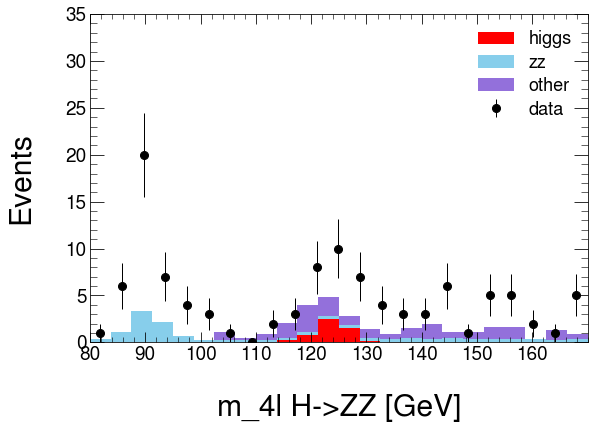

In [3]:
n_bins = 24
bin_range = (80, 170)
bin_edges = np.linspace(bin_range[0], bin_range[1], n_bins)
center_offset = (bin_range[1] - bin_range[0]) / 24. /2. 
bin_centers = center_offset + bin_edges

# merge with bin, low and high parameters taken from first histogram
def merge_series(label):
    x = None
    weights = None
    for i, d in enumerate(files[label]):
        sample = d[1]
        sample_x = df[sample].m4l.to_numpy()
        sample_weights = df[sample].weight.to_numpy()
        print(sample, sample_x)
        if i == 0: 
            x = sample_x
            weights = sample_weights
        else: 
            x = np.concatenate((x, sample_x), axis=None)
            weights = np.concatenate((weights, sample_weights), axis=None)
    return x, weights

data_x, data_weights = merge_series("data")
higgs_x, higgs_weights = merge_series("higgs")
zz_x, zz_weights = merge_series("zz")
other_x, other_weights = merge_series("other")

data_hist = np.histogram(data_x, bins=n_bins, range=bin_range, weights=data_weights)
higgs_hist = np.histogram(higgs_x, bins=n_bins, range=bin_range, weights=higgs_weights)
zz_hist = np.histogram(zz_x, bins=n_bins, range=bin_range, weights=zz_weights)
other_hist = np.histogram(other_x, bins=n_bins, range=bin_range, weights=other_weights)
print('Histograms & Weights:')
print('data:')
pp(data_hist)
pp(data_weights)

print('higgs:')
pp(higgs_hist)

print('zz:')
# Apply MC correction for ZZ due to missing gg->ZZ process
zz_hist = zz_hist[0]*1.3, zz_hist[1]
pp(zz_hist)

print('other:')
pp(other_hist)

x = np.array([data_x, higgs_x, zz_x, other_x])
pp(x.shape)
pp(x)
weights = np.array([data_weights, higgs_weights, zz_weights, other_weights])
pp(weights.shape)
pp(weights)

# counts, bins = higgs_hist
# plt.hist(bins[:-1], bins, weights=counts)

print(bin_centers.shape, data_hist[0].shape )
main_axes = plt.gca()
main_axes.errorbar(x=bin_centers, y=data_hist[0], yerr=np.sqrt(data_hist[0]), fmt='ko', label='data')
main_axes.hist([higgs_hist[1][:-1], zz_hist[1][:-1], other_hist[1][:-1]], bins=higgs_hist[1], histtype='bar', stacked=True, 
               label=['higgs', 'zz', 'other'], 
               weights=[higgs_hist[0], zz_hist[0], other_hist[0]],
               color=['red', 'skyblue', 'mediumpurple'])

plt.legend()
plt.xlim(bin_range[0], bin_range[1])
plt.ylim(0, 35)
plt.xlabel('m_4l H->ZZ [GeV]')
plt.ylabel('Events')
plt.xticks(np.arange(bin_range[0], bin_range[1], 10))
